Choose one option:
 A) Upload your CSV now
 B) Use synthetic demo (auto)
Please select your dataset CSV...


Saving synthetic_weekly_fever_data.csv to synthetic_weekly_fever_data (2).csv
Loaded: synthetic_weekly_fever_data (2).csv, df.shape=(1690, 9)
Rows after FE: 1014, features: 33


,fold,MAE,RMSE
0,1,0.504557,0.714614
1,2,0.355258,0.511481
2,3,0.314785,0.508657
3,4,0.198553,0.349446
4,5,0.163746,0.356621


Overall MAE: 0.307
Overall RMSE: 0.506


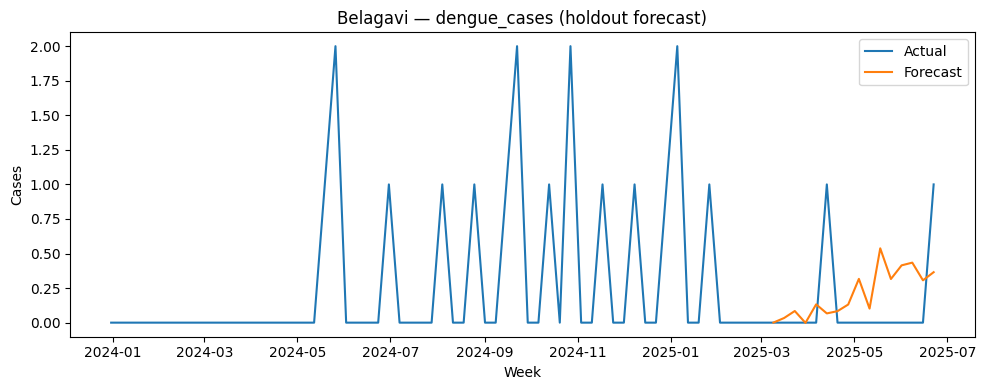

Saved forecasts -> /content/outputs/forecasts.csv
Saved risk bands -> /content/outputs/risk_bands.csv


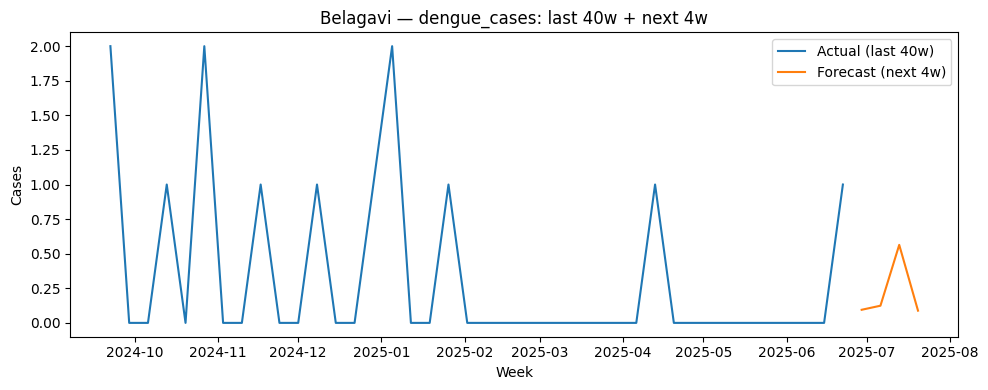


All done ✅  Submit these files from /content/outputs:
 - forecasts.csv
 - risk_bands.csv


In [ ]:
# ==========================================================
# Microlabs 2025 — Predictive Outbreak Models (Colab Script)
# District-week fever forecasting baseline with XGBoost
# ==========================================================

# 0) Setup
!pip -q install xgboost==2.0.3 pandas numpy matplotlib scikit-learn

import os, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from google.colab import files

plt.rcParams["figure.figsize"] = (10,4)
OUTDIR = "/content/outputs"
os.makedirs(OUTDIR, exist_ok=True)

# -----------------------------
# 1) DATA: Upload OR Synthetic
# -----------------------------
print("Choose one option:\n A) Upload your CSV now\n B) Use synthetic demo (auto)")
choice = "A"  # change to "B" to skip upload and use synthetic data

def make_synthetic():
    np.random.seed(42)
    states = ["Karnataka", "Maharashtra", "Tamil Nadu", "Kerala", "Delhi"]
    districts = {
        "Karnataka": ["Bengaluru Urban", "Mysuru", "Belagavi"],
        "Maharashtra": ["Mumbai", "Pune", "Nagpur"],
        "Tamil Nadu": ["Chennai", "Coimbatore", "Madurai"],
        "Kerala": ["Thiruvananthapuram", "Kochi", "Kozhikode"],
        "Delhi": ["New Delhi"]
    }
    start_date = datetime(2023,1,1)
    weeks = 130
    rows = []
    for w in range(weeks):
        date = start_date + timedelta(days=7*w)
        seasonal = 10 + 15*np.sin(2*np.pi*(w%52)/52)
        rain = max(0, np.sin(2*np.pi*((w+20)%52)/52)) * 100
        temp = 24 + 6*np.sin(2*np.pi*((w+10)%52)/52)
        for st in states:
            for dist in districts[st]:
                pop = 2_000_000 if any(k in dist for k in ["Bengaluru","Mumbai","Chennai"]) else 1_000_000
                dengue_lambda = max(0.1, 0.02*pop/100000 * (1+0.04*rain) * (1+0.02*seasonal))
                enteric_lambda = max(0.1, 0.015*pop/100000 * (1+0.01*rain) * (1+0.03*(30-temp)))
                chik_lambda = max(0.1, 0.01*pop/100000 * (1+0.03*rain) * (1+0.01*seasonal))
                rows.append({
                    "week_start": date,
                    "state": st,
                    "district": dist,
                    "population": pop,
                    "rain_mm": round(rain + np.random.normal(0,5),2),
                    "temp_c": round(temp + np.random.normal(0,0.8),2),
                    "dengue_cases": np.random.poisson(dengue_lambda),
                    "enteric_fever_cases": np.random.poisson(enteric_lambda),
                    "chikungunya_cases": np.random.poisson(chik_lambda)
                })
    return pd.DataFrame(rows)

try:
    if choice.upper().startswith("A"):
        print("Please select your dataset CSV...")
        uploaded = files.upload()
        csv_name = list(uploaded.keys())[0]
        df = pd.read_csv(io.BytesIO(uploaded[csv_name]), parse_dates=["week_start"])
        print(f"Loaded: {csv_name}, df.shape={df.shape}")
    else:
        raise Exception("Using synthetic demo")
except:
    df = make_synthetic()
    print("Loaded synthetic demo dataset:", df.shape)

# Required columns
required = {
    "week_start","state","district","population","rain_mm","temp_c",
    "dengue_cases","enteric_fever_cases","chikungunya_cases"
}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# -----------------------------
# 2) CONFIG: choose target col
# -----------------------------
TARGET = "dengue_cases"   # or 'enteric_fever_cases' or 'chikungunya_cases'

# -----------------------------
# 3) FEATURE ENGINEERING
# (no include_groups; use transform/shift)
# -----------------------------
df = df.copy()
df["week_start"] = pd.to_datetime(df["week_start"])
df = df.sort_values(["district","week_start"]).reset_index(drop=True)
df["week"] = df["week_start"].dt.isocalendar().week.astype(int)
df["year"] = df["week_start"].dt.year.astype(int)

# Lags (vectorized; no apply)
lags_used = (1,2,3,4,6,8,12,26,52)
for col in [TARGET, "rain_mm", "temp_c"]:
    g = df.groupby("district")[col]
    for L in lags_used:
        df[f"{col}_lag{L}"] = g.shift(L)

# Rolling stats via transform (per-district)
df["y_roll4"]  = df.groupby("district")[TARGET].transform(lambda s: s.rolling(4).mean())
df["y_roll12"] = df.groupby("district")[TARGET].transform(lambda s: s.rolling(12).mean())

# Drop rows with NaNs after lagging/rolling
df = df.dropna().reset_index(drop=True)

# Build SAFE feature list (avoid timestamps & target)
safe_base_feats = ["rain_mm", "temp_c", "week", "year"]
feature_cols = [c for c in df.columns if ("_lag" in c) or ("roll" in c) or (c in safe_base_feats)]
assert "week_start" not in feature_cols
assert TARGET not in feature_cols

# Ensure numeric dtypes for XGBoost
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce")
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df = df.dropna(subset=feature_cols + [TARGET]).reset_index(drop=True)

X = df[feature_cols].values
y = df[TARGET].values

print(f"Rows after FE: {len(df)}, features: {len(feature_cols)}")

# -----------------------------
# 4) ROLLING TIME-SERIES CV
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)
preds, trues, fold_metrics = [], [], []

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X), 1):
    Xtr, Xte = X[tr_idx], X[te_idx]
    ytr, yte = y[tr_idx], y[te_idx]
    model = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)
    mae = mean_absolute_error(yte, yhat)
    rmse = math.sqrt(mean_squared_error(yte, yhat))
    fold_metrics.append({"fold": fold, "MAE": mae, "RMSE": rmse})
    preds.append(yhat); trues.append(yte)

metrics_df = pd.DataFrame(fold_metrics)
display(metrics_df)
print("Overall MAE:", round(mean_absolute_error(np.concatenate(trues), np.concatenate(preds)), 3))
print("Overall RMSE:", round(math.sqrt(mean_squared_error(np.concatenate(trues), np.concatenate(preds))), 3))

# -----------------------------
# 5) HOLDOUT PLOT (one district)
# -----------------------------
sample_dist = df["district"].unique()[0]  # change if desired
sample = df[df["district"] == sample_dist].copy()
cut = int(len(sample) * 0.8)

m = XGBRegressor(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror", random_state=42
)
m.fit(sample.iloc[:cut][feature_cols], sample.iloc[:cut][TARGET])
sample["yhat"] = np.nan
sample.loc[sample.index[cut]:, "yhat"] = m.predict(sample.iloc[cut:][feature_cols])

plt.figure()
plt.plot(sample["week_start"], sample[TARGET], label="Actual")
plt.plot(sample["week_start"], sample["yhat"], label="Forecast")
plt.title(f"{sample_dist} — {TARGET} (holdout forecast)")
plt.xlabel("Week"); plt.ylabel("Cases"); plt.legend(); plt.tight_layout()
plt.show()

# -----------------------------
# 6) 4-WEEK-AHEAD FORECASTS
# -----------------------------
def one_step_feature_row(tmp_df, next_date):
    """Build a single 'future' row using last known/extrapolated values and lag shifting."""
    row = tmp_df.iloc[[-1]].copy()
    row["week_start"] = next_date
    row["year"] = int(next_date.year)
    row["week"] = int(pd.Timestamp(next_date).isocalendar().week)

    # carry-forward exogenous (rain/temp); replace with weather forecasts if available
    last_rain = float(tmp_df["rain_mm"].iloc[-1])
    last_temp = float(tmp_df["temp_c"].iloc[-1])
    row["rain_mm"] = last_rain
    row["temp_c"] = last_temp

    # update lags from tmp_df (use exact -L index if available)
    for base in [TARGET, "rain_mm", "temp_c"]:
        for L in lags_used:
            if len(tmp_df) >= L:
                row[f"{base}_lag{L}"] = float(tmp_df[base].iloc[-L])
            else:
                row[f"{base}_lag{L}"] = float(tmp_df[base].iloc[0])

    # rolling means based on history
    row["y_roll4"]  = tmp_df[TARGET].rolling(4).mean().iloc[-1] if len(tmp_df) >= 4 else tmp_df[TARGET].mean()
    row["y_roll12"] = tmp_df[TARGET].rolling(12).mean().iloc[-1] if len(tmp_df) >= 12 else tmp_df[TARGET].mean()
    return row

def forecast_next_weeks(df_dist, weeks_ahead=4):
    dfw = df_dist.sort_values("week_start").copy()

    # fit on all available rows for this district
    mdl = XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror", random_state=42
    )
    mdl.fit(dfw[feature_cols], dfw[TARGET])

    last_date = dfw["week_start"].max()
    fcasts = []
    tmp = dfw.copy()

    for h in range(1, weeks_ahead+1):
        next_date = last_date + timedelta(days=7*h)
        row = one_step_feature_row(tmp, next_date)
        # predict next TARGET
        yhat = float(mdl.predict(row[feature_cols])[0])
        row[TARGET] = max(0.0, yhat)   # non-negative
        tmp = pd.concat([tmp, row], ignore_index=True)
        fcasts.append({"week_start": next_date, "yhat": max(0.0, yhat)})

        # Optional: refit at each step (commented for speed)
        # mdl.fit(tmp.iloc[:-1][feature_cols], tmp.iloc[:-1][TARGET])

    return pd.DataFrame(fcasts)

all_forecasts = []
for dist in df["district"].unique():
    dsub = df[df["district"] == dist].copy()
    fc = forecast_next_weeks(dsub, weeks_ahead=4)
    fc["district"] = dist
    fc["state"] = dsub["state"].iloc[0]
    all_forecasts.append(fc)

fc_df = pd.concat(all_forecasts, ignore_index=True)
fc_df = fc_df[["week_start","state","district","yhat"]].sort_values(["state","district","week_start"])
fc_path = os.path.join(OUTDIR, "forecasts.csv")
fc_df.to_csv(fc_path, index=False)
print(f"Saved forecasts -> {fc_path}")

# -----------------------------
# 7) RISK BANDS (Green/Amber/Red)
# -----------------------------
risk = []
for dist in df["district"].unique():
    hist = df[df["district"]==dist][TARGET]
    q75, q90 = hist.quantile(0.75), hist.quantile(0.90)
    tmp = fc_df[fc_df["district"]==dist].copy()

    def band(x):
        if x >= q90: return "Red"
        if x >= q75: return "Amber"
        return "Green"

    tmp["risk_band"] = tmp["yhat"].apply(band)
    risk.append(tmp)

risk_df = pd.concat(risk, ignore_index=True)
risk_path = os.path.join(OUTDIR, "risk_bands.csv")
risk_df.to_csv(risk_path, index=False)
print(f"Saved risk bands -> {risk_path}")

# -----------------------------
# 8) SUMMARY PLOT (last 40w + next 4w)
# -----------------------------
d0 = df["district"].unique()[0]
plt.figure()
hist = df[df["district"]==d0][["week_start", TARGET]].tail(40).copy()
plt.plot(hist["week_start"], hist[TARGET], label="Actual (last 40w)")
future = risk_df[risk_df["district"]==d0][["week_start","yhat"]]
plt.plot(future["week_start"], future["yhat"], label="Forecast (next 4w)")
plt.title(f"{d0} — {TARGET}: last 40w + next 4w")
plt.xlabel("Week"); plt.ylabel("Cases"); plt.legend(); plt.tight_layout()
plt.show()

print("\nAll done ✅  Submit these files from /content/outputs:")
print(" - forecasts.csv")
print(" - risk_bands.csv")

# (Optional) Save to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/outputs/*.csv /content/drive/MyDrive/


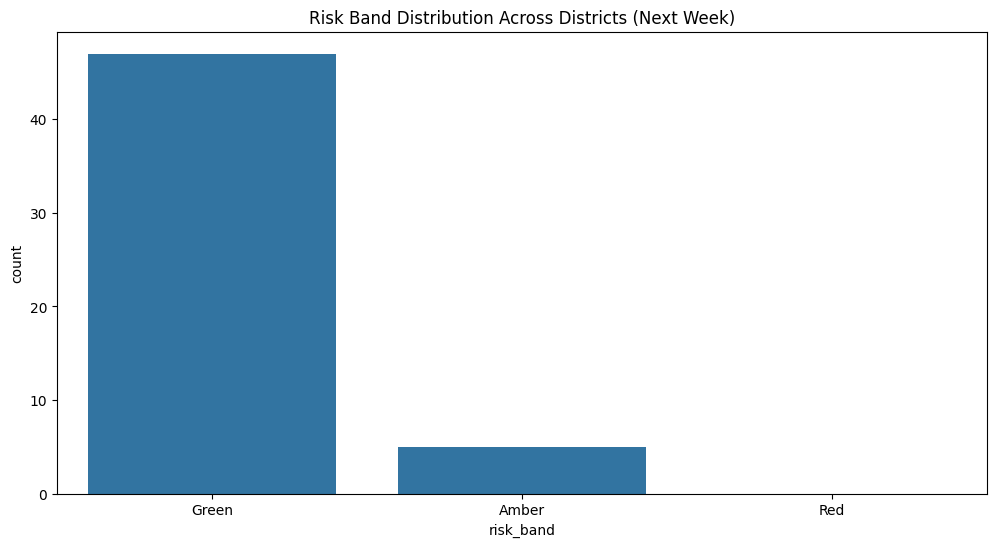

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(data=risk_df, x="risk_band", order=["Green","Amber","Red"])
plt.title("Risk Band Distribution Across Districts (Next Week)")
plt.show()